In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.datasets import load_iris
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D

# Impostazioni per i grafici
plt.rcParams['figure.figsize'] = (12, 8)


Dimensioni del dataset: (150, 4)

Prime 5 righe del dataset:
   sepal length (cm)  sepal width (cm)  petal length (cm)  petal width (cm)  \
0                5.1               3.5                1.4               0.2   
1                4.9               3.0                1.4               0.2   
2                4.7               3.2                1.3               0.2   
3                4.6               3.1                1.5               0.2   
4                5.0               3.6                1.4               0.2   

  species  
0  setosa  
1  setosa  
2  setosa  
3  setosa  
4  setosa  

Informazioni statistiche:
       sepal length (cm)  sepal width (cm)  petal length (cm)  \
count         150.000000        150.000000         150.000000   
mean            5.843333          3.057333           3.758000   
std             0.828066          0.435866           1.765298   
min             4.300000          2.000000           1.000000   
25%             5.100000          2.8000

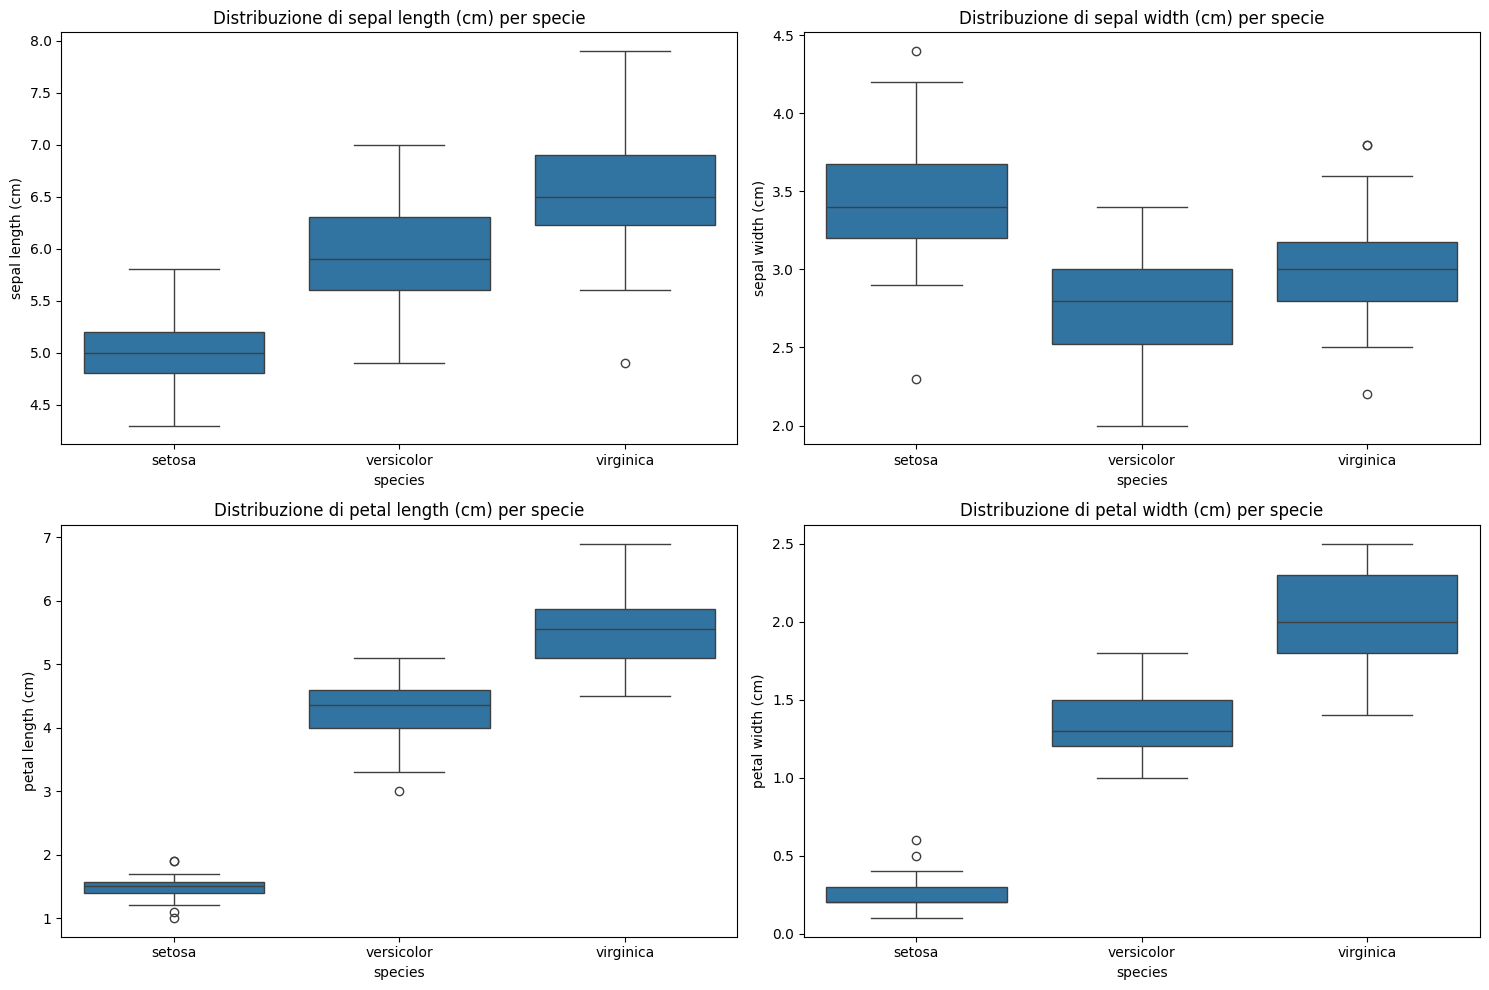

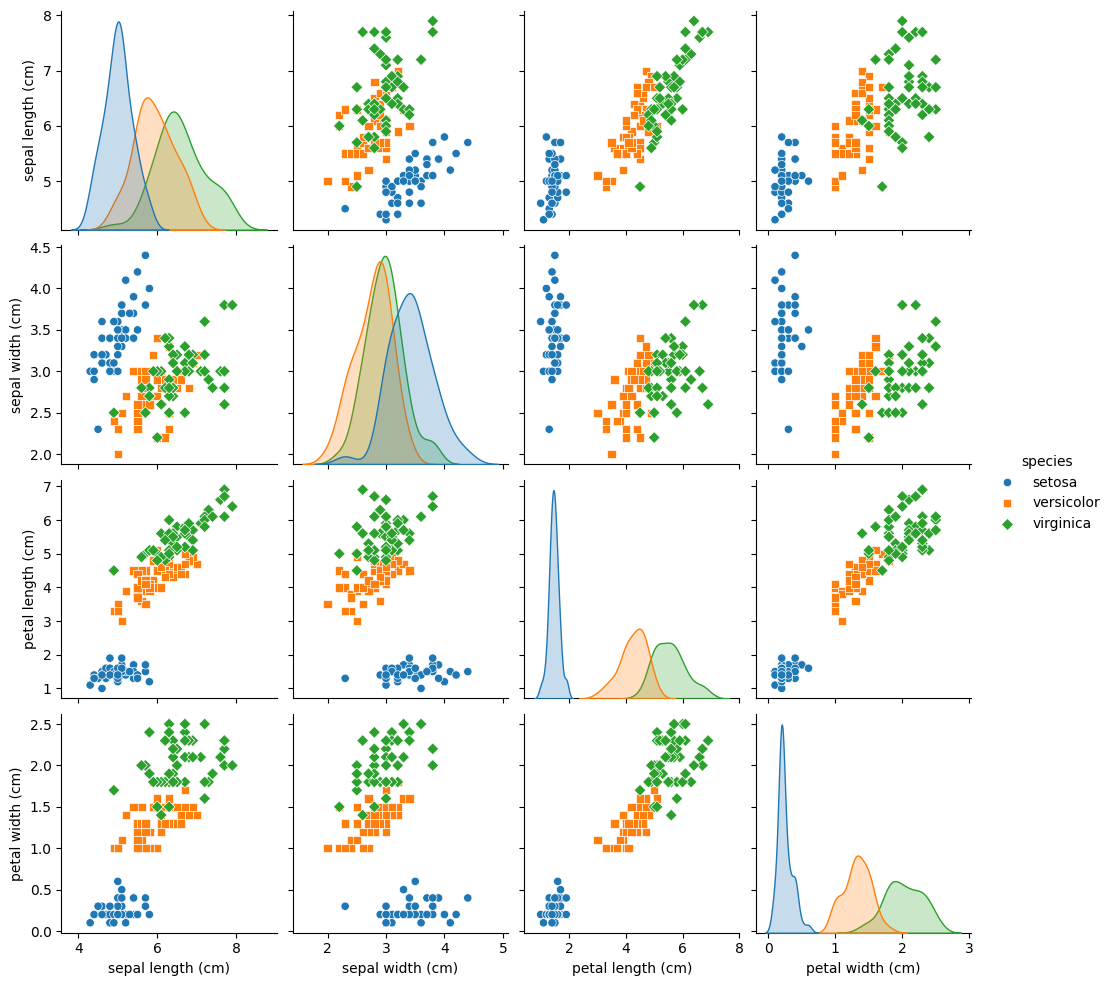

In [2]:
# -------------------------------------------------------------------------
# 1. Caricamento e esplorazione del dataset Iris
# -------------------------------------------------------------------------
iris = load_iris()
X = iris.data
y = iris.target
feature_names = iris.feature_names
target_names = iris.target_names

# Creiamo un DataFrame per una migliore visualizzazione
iris_df = pd.DataFrame(X, columns=feature_names)
iris_df['species'] = pd.Categorical.from_codes(y, target_names)

print("Dimensioni del dataset:", X.shape)
print("\nPrime 5 righe del dataset:")
print(iris_df.head())

print("\nInformazioni statistiche:")
print(iris_df.describe())

# Visualizziamo la distribuzione delle variabili per ogni specie
plt.figure(figsize=(15, 10))
for i, feature in enumerate(feature_names):
    plt.subplot(2, 2, i+1)
    sns.boxplot(x='species', y=feature, data=iris_df)
    plt.title(f'Distribuzione di {feature} per specie')
plt.tight_layout()
plt.savefig('iris_features_distribution.png')

# Matrice di scatter plot per visualizzare le relazioni tra le variabili
sns.pairplot(iris_df, hue='species', markers=["o", "s", "D"])
plt.savefig('iris_pairplot.png')

In [3]:
# -------------------------------------------------------------------------
# 2. Preprocessing dei dati
# -------------------------------------------------------------------------
# Standardizziamo i dati per avere media 0 e deviazione standard 1
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print("\nDati dopo la standardizzazione (prime 5 righe):")
print(pd.DataFrame(X_scaled[:5], columns=feature_names))



Dati dopo la standardizzazione (prime 5 righe):
   sepal length (cm)  sepal width (cm)  petal length (cm)  petal width (cm)
0          -0.900681          1.019004          -1.340227         -1.315444
1          -1.143017         -0.131979          -1.340227         -1.315444
2          -1.385353          0.328414          -1.397064         -1.315444
3          -1.506521          0.098217          -1.283389         -1.315444
4          -1.021849          1.249201          -1.340227         -1.315444



WCSS per diversi valori di k:
k=2: 222.36
k=3: 139.82
k=4: 114.09
k=5: 90.93
k=6: 81.54
k=7: 72.63
k=8: 62.54
k=9: 55.12
k=10: 47.39

Silhouette Score per diversi valori di k:
k=2: 0.5818
k=3: 0.4599
k=4: 0.3869
k=5: 0.3459
k=6: 0.3171
k=7: 0.3202
k=8: 0.3387
k=9: 0.3424


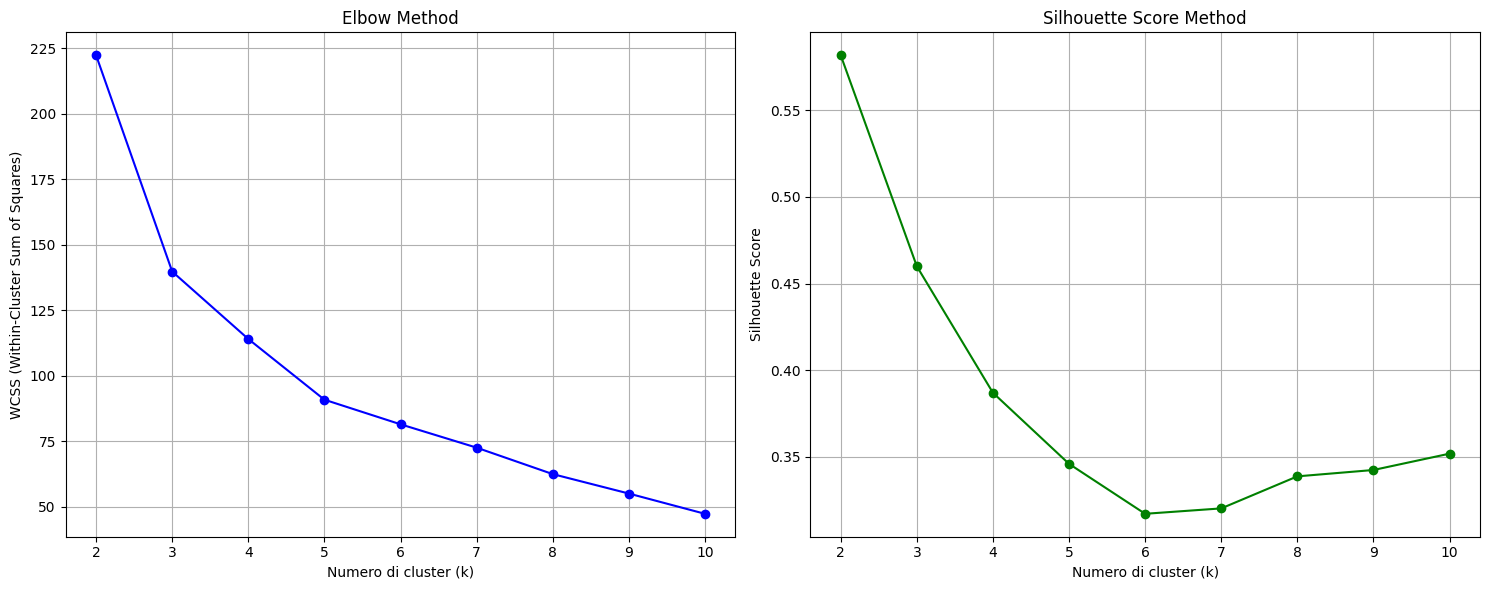

In [4]:
# -------------------------------------------------------------------------
# 3. Determinazione del numero ottimale di cluster con Elbow Method
# -------------------------------------------------------------------------
wcss = []  # Within-Cluster Sum of Square o inerzia
silhouette_scores = []
k_range = range(2, 11)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_scaled)
    wcss.append(kmeans.inertia_)
    
    # Calcoliamo anche il silhouette score
    if k > 1:  # Silhouette score è definito per k >= 2
        labels = kmeans.labels_
        silhouette_scores.append(silhouette_score(X_scaled, labels))

# Visualizziamo l'Elbow Method
plt.figure(figsize=(15, 6))

plt.subplot(1, 2, 1)
plt.plot(k_range, wcss, 'o-', color='blue')
plt.title('Elbow Method')
plt.xlabel('Numero di cluster (k)')
plt.ylabel('WCSS (Within-Cluster Sum of Squares)')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(k_range, silhouette_scores, 'o-', color='green')
plt.title('Silhouette Score Method')
plt.xlabel('Numero di cluster (k)')
plt.ylabel('Silhouette Score')
plt.grid(True)

plt.tight_layout()
plt.savefig('kmeans_optimal_k.png')

# Stampiamo anche i valori numerici
print("\nWCSS per diversi valori di k:")
for k, inertia in zip(k_range, wcss):
    print(f"k={k}: {inertia:.2f}")

print("\nSilhouette Score per diversi valori di k:")
for k, score in zip(k_range[:-1], silhouette_scores):
    print(f"k={k}: {score:.4f}")



In [10]:
# -------------------------------------------------------------------------
# 4. Applicazione di K-means con k=3 seguendo il gomito
# -------------------------------------------------------------------------
kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
y_kmeans = kmeans.fit_predict(X_scaled)

# Aggiungiamo le etichette dei cluster al DataFrame
iris_df['cluster'] = y_kmeans

# Valutiamo la corrispondenza tra cluster e specie
cluster_species_crosstab = pd.crosstab(
    index=iris_df['cluster'], 
    columns=iris_df['species'], 
    rownames=['Cluster'], 
    colnames=['Species']
)
print("\nCorrispondenza tra cluster e specie:")
print(cluster_species_crosstab)

# Calcoliamo l'accuratezza (semplificata - assumendo la migliore corrispondenza)
total_correct = 0
for i in range(3):
    total_correct += cluster_species_crosstab.iloc[i].max()
accuracy = total_correct / len(iris_df)

print(f"\nAccuratezza (semplificata): {accuracy:.4f}")


Corrispondenza tra cluster e specie:
Species  setosa  versicolor  virginica
Cluster                               
0             0          39         14
1            50           0          0
2             0          11         36

Accuratezza (semplificata): 0.8333


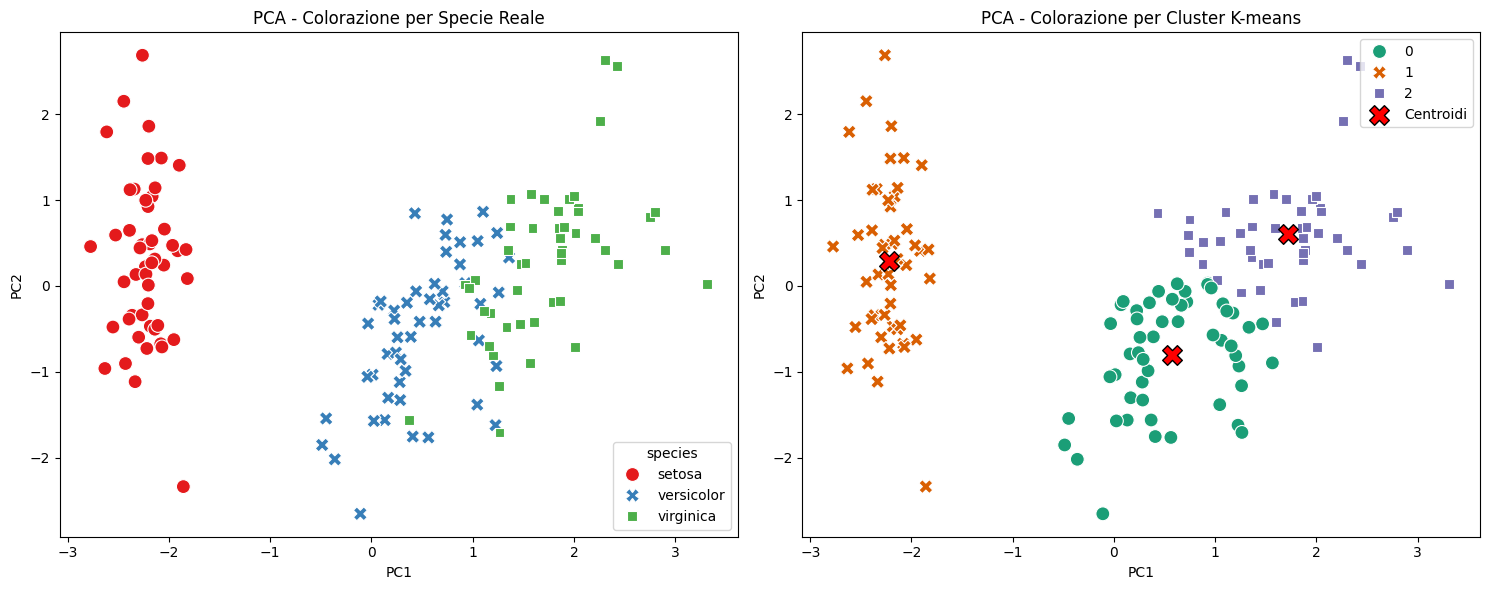

In [11]:
# -------------------------------------------------------------------------
# 5. Visualizzazione dei risultati con PCA per ridurre a 2 dimensioni
# -------------------------------------------------------------------------
# Utilizziamo PCA per ridurre a 2 dimensioni per la visualizzazione
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Creiamo un DataFrame con i dati PCA
pca_df = pd.DataFrame(
    data=X_pca, 
    columns=['PC1', 'PC2']
)
pca_df['species'] = iris_df['species']
pca_df['cluster'] = iris_df['cluster']

# Visualizziamo i dati trasformati con PCA, colorati per specie reale
plt.figure(figsize=(15, 6))

plt.subplot(1, 2, 1)
sns.scatterplot(
    x='PC1', 
    y='PC2', 
    hue='species',
    style='species',
    palette='Set1',
    data=pca_df,
    s=100
)
plt.title('PCA - Colorazione per Specie Reale')

# Visualizziamo i dati trasformati con PCA, colorati per cluster
plt.subplot(1, 2, 2)
sns.scatterplot(
    x='PC1', 
    y='PC2', 
    hue='cluster',
    style='cluster',
    palette='Dark2',
    data=pca_df,
    s=100
)

# Aggiungiamo i centroidi
centroids_pca = pca.transform(kmeans.cluster_centers_)
plt.scatter(
    centroids_pca[:, 0], 
    centroids_pca[:, 1], 
    s=200, 
    marker='X', 
    c='red', 
    edgecolors='black',
    label='Centroidi'
)
plt.title('PCA - Colorazione per Cluster K-means')
plt.legend()

plt.tight_layout()



--- Confronto Inizializzazione Random vs k-means++ ---

Inizializzazione Random:
Inertia: 145.47 ± 15.19
Silhouette Score: 0.4605 ± 0.0069

Inizializzazione k-means++:
Inertia: 145.44 ± 15.20
Silhouette Score: 0.4609 ± 0.0068


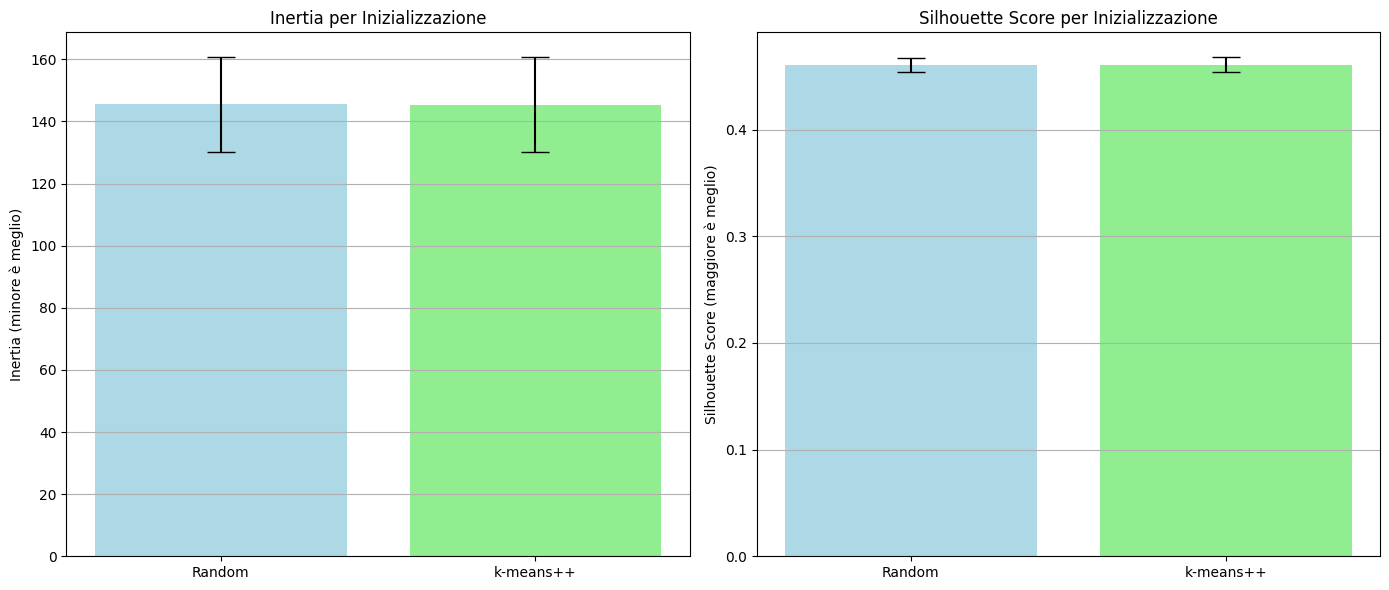

In [12]:
# -------------------------------------------------------------------------
# 6. Inizializzazione intelligente con k-means++
# -------------------------------------------------------------------------
print("\n--- Confronto Inizializzazione Random vs k-means++ ---")

# Funzione per valutare k-means con diverse inizializzazioni
def evaluate_kmeans(init_method, n_runs=10):
    inertia_values = []
    silhouette_values = []
    
    for i in range(n_runs):
        kmeans = KMeans(n_clusters=3, init=init_method, random_state=i, n_init=1)
        kmeans.fit(X_scaled)
        inertia_values.append(kmeans.inertia_)
        silhouette_values.append(silhouette_score(X_scaled, kmeans.labels_))
    
    return {
        'inertia_mean': np.mean(inertia_values),
        'inertia_std': np.std(inertia_values),
        'silhouette_mean': np.mean(silhouette_values),
        'silhouette_std': np.std(silhouette_values)
    }

# Valutiamo con inizializzazione random
random_init_results = evaluate_kmeans('random')

# Valutiamo con inizializzazione k-means++
kmeans_plus_results = evaluate_kmeans('k-means++')

# Stampiamo i risultati
print("\nInizializzazione Random:")
print(f"Inertia: {random_init_results['inertia_mean']:.2f} ± {random_init_results['inertia_std']:.2f}")
print(f"Silhouette Score: {random_init_results['silhouette_mean']:.4f} ± {random_init_results['silhouette_std']:.4f}")

print("\nInizializzazione k-means++:")
print(f"Inertia: {kmeans_plus_results['inertia_mean']:.2f} ± {kmeans_plus_results['inertia_std']:.2f}")
print(f"Silhouette Score: {kmeans_plus_results['silhouette_mean']:.4f} ± {kmeans_plus_results['silhouette_std']:.4f}")

# Visualizziamo i risultati in un grafico a barre
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
methods = ['Random', 'k-means++']
inertia_means = [random_init_results['inertia_mean'], kmeans_plus_results['inertia_mean']]
inertia_stds = [random_init_results['inertia_std'], kmeans_plus_results['inertia_std']]

plt.bar(methods, inertia_means, yerr=inertia_stds, capsize=10, color=['lightblue', 'lightgreen'])
plt.title('Inertia per Inizializzazione')
plt.ylabel('Inertia (minore è meglio)')
plt.grid(axis='y')

plt.subplot(1, 2, 2)
silhouette_means = [random_init_results['silhouette_mean'], kmeans_plus_results['silhouette_mean']]
silhouette_stds = [random_init_results['silhouette_std'], kmeans_plus_results['silhouette_std']]

plt.bar(methods, silhouette_means, yerr=silhouette_stds, capsize=10, color=['lightblue', 'lightgreen'])
plt.title('Silhouette Score per Inizializzazione')
plt.ylabel('Silhouette Score (maggiore è meglio)')
plt.grid(axis='y')

plt.tight_layout()

